<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Experiments/CyclicLearningRate_TFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Addons Optimizers: Cyclical Learning Rate

Being a very big fan of Fastai's tweaks on finding the best learning rate, looking at this Cyclic Learning rate gets me feel excited! 

Will be going through the tutorial book on TensorFlow Addons. 

https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate

## Cyclical Learning Rates 

- It has been shown it is benefical to adjust the learning rate as train progresses for a neural network. 
- This was founded by Leslie Smith on his paper [Cyclic Learning Rates](https://arxiv.org/abs/1506.01186)
- He noticed that we would want to increase the learning rate to traverse factor across the loss landscape but we would also want to reduce the learning rate when approaching convergence. 

It's an idea where you would adjust the learning rate with respect to cycles of a function. 

https://www.jeremyjordan.me/nn-learning-rate/

In [1]:
# Downloading tensorflow_addons 
!pip install -q -U tensorflow_addons 

     |████████████████████████████████| 686kB 22.2MB/s 


In [2]:
# Importing the things we need 
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Setting the seed for reproducibility 
tf.random.set_seed(42)
np.random.seed(42)


In [3]:
# Load and prepare the data (we're going to use fashion mnist)
(X_train , y_train) , (X_test , y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Checking the shapes of our data
X_train.shape , y_train.shape , X_test.shape , y_test.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
# Adding an extra dimension 
X_train = np.expand_dims(X_train , axis = -1)
X_test = np.expand_dims(X_test , axis = -1)

# Checking the shapes after adding an extra dimension
X_train.shape , y_train.shape , X_test.shape , y_test.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

In [5]:
# Defining the important Hyper parameters 
BATCH_SIZE = 64 
EPOCHS = 10 
INIT_LR = 1e-4 # initial learning rate (start)
MAX_LR = 1e-2 # maximum learning rate (end)
IMG_SHAPE = (28 , 28 , 1)

In [6]:
# Creating a function for building the model 
def get_training_model():
  model = tf.keras.Sequential([
    layers.InputLayer(IMG_SHAPE) , 
    layers.experimental.preprocessing.Rescaling(scale = 1/255.), 
    layers.Conv2D(16 , (5 , 5) , activation = 'relu'), 
    layers.MaxPooling2D((2, 2)) , 
    layers.Conv2D(32 , (5 , 5) , activation = 'relu'), 
    layers.MaxPooling2D((2 , 2)), 
    layers.SpatialDropout2D(0.2), 
    layers.GlobalAvgPool2D() ,
    layers.Dense(128 , activation = 'relu'),
    layers.Dense(10 , activation= 'softmax')

])
  return model

In [7]:
# Function for training the model 
def train_model(model , optimizer, epochs):
  model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                optimizer = optimizer , 
                metrics = ['accuracy'])
  
  # Fitting the model 
  history = model.fit(X_train , y_train , 
                      batch_size = BATCH_SIZE , 
                      validation_data = (X_test , y_test) , 
                      epochs = epochs)
  
  return history

In [8]:
# Model we are going to train without clr
initial_model = get_training_model()
initial_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 4, 4, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0

In [9]:
# Saving this model 
initial_model.save('initial_model')

INFO:tensorflow:Assets written to: initial_model/assets


### Training a model without Cyclic Learning Rate 

In [10]:
standard_model = tf.keras.models.load_model('initial_model')
no_clr_history = train_model(model= standard_model , 
                             optimizer = tf.keras.optimizers.SGD() , 
                             epochs = EPOCHS)

Epoch 1/10
938/938 [==============================] - 35s 4ms/step - loss: 2.2093 - accuracy: 0.2181 - val_loss: 1.7610 - val_accuracy: 0.4113
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 1.2965 - accuracy: 0.5129 - val_loss: 0.9588 - val_accuracy: 0.6495
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 1.0106 - accuracy: 0.6181 - val_loss: 0.9148 - val_accuracy: 0.6589
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.9279 - accuracy: 0.6568 - val_loss: 0.8493 - val_accuracy: 0.7014
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.8858 - accuracy: 0.6721 - val_loss: 0.8407 - val_accuracy: 0.6661
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.8483 - accuracy: 0.6848 - val_loss: 0.7970 - val_accuracy: 0.6834
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.8219 - accuracy: 0.6944 - val_loss: 0.7612 - val_accuracy: 0.7004
Epoch

### Defining CLR Schedule 

The `tfa.optimizers.CyclicalLearningRate` module return a direct schedule that can be passed to an optimizer. 

> The schedule takes a step as it's input and ouputs a value calculated using CLR formula laid out in the paper. 

In [11]:
# Calculating steps per epoch 
steps_per_epoch = len(X_train) // BATCH_SIZE
steps_per_epoch

937

In [12]:
# Defining our cyclic learning rate 
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate= INIT_LR , 
                                          maximal_learning_rate = MAX_LR , 
                                          scale_fn = lambda x: 1/(2.**(x-1)) , 
                                          step_size = 2*steps_per_epoch)

# Passing this into our optimizer 
optimizer = tf.keras.optimizers.SGD(clr)

- Here, we specify the lower and upper bounds of the learning rate (initial and max lr) and the **schedule will oscillate in between that range [1e-4 , 1e-2]**.

- The **`scale_fn` is used to define the function that would scale up and scale down the learning rate within a given cycle**. 

- The `step_size` defines the **duration of single cycle**. 

In our example we used **2** in `step_size` that means you need a total of 4 iterations to complete one cycle. 

`factor * steps_per_epoch` where factor lies within the [2, 8] range.

CLR paper: https://arxiv.org/abs/1506.01186

This [blog post](https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/) provides a nice detail of how to choose the bounds for learning rate.


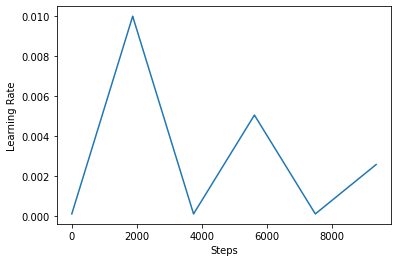

In [13]:
# Visualizing how our clr scheduler works 

step = np.arange(0 , EPOCHS * steps_per_epoch)
lr = clr(step= step)
plt.plot(step , lr)
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.show()

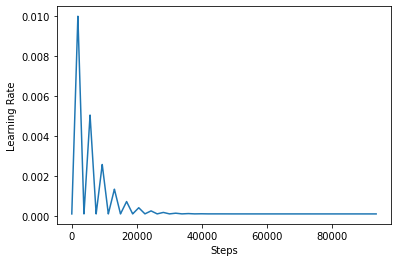

In [14]:
step = np.arange(0 , 100  * steps_per_epoch)
lr = clr(step)
plt.plot(step , lr)
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.show()

> The scale function we are using in this tutorial is referred to as the `triangular2` method in the **CLR paper**. There are other two functions there were explored namely `triangular` and `exp`. 

### Train a model with CLR 

In [16]:
clr_model = tf.keras.models.load_model('initial_model')
clr_history = train_model(model = clr_model , 
                          optimizer = optimizer, # with clr
                          epochs = EPOCHS)

Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 2.3005 - accuracy: 0.1165 - val_loss: 2.2851 - val_accuracy: 0.2369
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 2.1930 - accuracy: 0.2398 - val_loss: 1.7382 - val_accuracy: 0.4522
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 1.3131 - accuracy: 0.5053 - val_loss: 1.0111 - val_accuracy: 0.6489
Epoch 4/10
938/938 [==============================] - 4s 5ms/step - loss: 1.0748 - accuracy: 0.5931 - val_loss: 0.9493 - val_accuracy: 0.6622
Epoch 5/10
938/938 [==============================] - 4s 5ms/step - loss: 1.0530 - accuracy: 0.6031 - val_loss: 0.9440 - val_accuracy: 0.6519
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 1.0200 - accuracy: 0.6172 - val_loss: 0.9102 - val_accuracy: 0.6613
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.9779 - accuracy: 0.6342 - val_loss: 0.8784 - val_accuracy: 0.6745
Epoch 

We could see the at the very beginning the loss was higher than usual and then it gets lower as the cycle progress. 

We can visualize by plotting the losses.

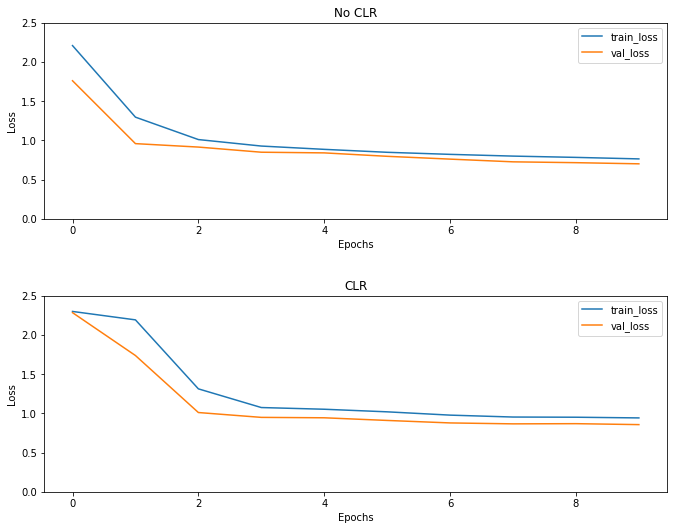

In [17]:
# Copied the code 
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(no_clr_history.history["loss"], label="train_loss")
ax[0].plot(no_clr_history.history["val_loss"], label="val_loss")
ax[0].set_title("No CLR")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 2.5])
ax[0].legend()

ax[1].plot(clr_history.history["loss"], label="train_loss")
ax[1].plot(clr_history.history["val_loss"], label="val_loss")
ax[1].set_title("CLR")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_ylim([0, 2.5])
ax[1].legend()

fig.tight_layout(pad=3.0)
fig.show()

## Applying on a different dataset

In [18]:
# Importing tensorflow datasets 
import tensorflow_datasets as tfds
train_data  , ds_info = tfds.load('cats_vs_dogs' , 
                                  split = 'train' , 
                                  with_info = True , 
                                  as_supervised = True # removes the filenames
                                        )

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete0PIQ9A/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [19]:
train_data.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [20]:
# Defining a preprocess function 
def preprocess_func(image , label):
  image = tf.image.resize(image , size = [224 , 224])
  return tf.cast(image , tf.float32) , label

In [21]:
# Applying the preprocess function and enabling prefetching 
train_data = train_data.map(map_func= preprocess_func , num_parallel_calls= tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
train_data = train_data.batch(64)

In [22]:
train_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [26]:
# Function to build our model 
base_model = tf.keras.applications.ResNet101(include_top= False)
base_model.trainable = False

inputs = layers.Input(shape= (224 , 224 , 3), name='input_layer')
x = layers.experimental.preprocessing.Rescaling(1 / 255.)(inputs)
x = base_model(x , training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64 , activation= 'relu')(x)
outputs = layers.Dense(1 , activation= 'sigmoid')(x)

# Packing into a model
model = tf.keras.Model(inputs , outputs)
model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet101 (Functional)       (None, None, None, 2048)  42658176  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 42,789,377
Trainable params: 131,201
Non-trainable params: 42,658,176
_________________________________________

In [27]:
# Defining the steps per epoch 
BATCH_SIZE = 64
steps_per_epoch = ds_info.splits.total_num_examples // BATCH_SIZE
steps_per_epoch

363

In [34]:
# Creating the Cyclic Learning Rate Scheduler 

clr_new = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate = 1e-4 , 
    maximal_learning_rate = 1e-3 , 
    scale_fn = lambda x: 1/(2. ** (x-1)) , 
    step_size = 2 * steps_per_epoch
)



In [29]:
# Saving the model 
model.save('uncompiled_resnet_model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: uncompiled_resnet_model/assets


INFO:tensorflow:Assets written to: uncompiled_resnet_model/assets


In [30]:
# Compile the model 
model.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
              optimizer = tf.keras.optimizers.Adam() , 
              metrics = ['accuracy'])

In [31]:
# Fitting without clr scheduler 
no_clr_history = model.fit(train_data , 
                           epochs = 3) 


Epoch 1/3
364/364 [==============================] - 130s 335ms/step - loss: 0.6492 - accuracy: 0.6211
Epoch 2/3
364/364 [==============================] - 122s 334ms/step - loss: 0.6119 - accuracy: 0.6691
Epoch 3/3
364/364 [==============================] - 121s 333ms/step - loss: 0.5963 - accuracy: 0.6833


In [32]:
# Fitting the model with clr 
loaded_model = tf.keras.models.load_model('uncompiled_resnet_model')
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet101 (Functional)       (None, None, None, 2048)  42658176  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 42,789,377
Trainable params: 131,201
Non-trainable params: 42,658,176
_________________________________________

In [35]:
# Compile the model 
loaded_model.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
              optimizer = tf.keras.optimizers.Adam(clr_new) , 
              metrics = ['accuracy'])

In [36]:
# Fitting the model 
with_clr_history = loaded_model.fit(train_data ,
                    epochs = 3 )

Epoch 1/3
364/364 [==============================] - 129s 336ms/step - loss: 0.6714 - accuracy: 0.5824
Epoch 2/3
364/364 [==============================] - 122s 335ms/step - loss: 0.6335 - accuracy: 0.6443
Epoch 3/3
364/364 [==============================] - 122s 335ms/step - loss: 0.6058 - accuracy: 0.6736


In [41]:
# Unfreezing the layers 
model.layers[2].trainable = True 

# Refreeze every layer except the last 5 
for layer in model.layers[2].layers[:-5]:
  layer.trainable = True


In [42]:
for layer in model.layers:
  print(layer.name , layer.trainable , layer.dtype)

input_layer True float32
rescaling_4 True float32
resnet101 True float32
global_average_pooling2d_4 True float32
dense_3 True float32
dense_4 True float32


In [45]:
# Compiling the model after making changes
model.compile(loss = tf.keras.losses.BinaryCrossentropy() ,
              optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001) , 
              metrics = ['accuracy'])

In [44]:
# Cyclic Learning Rate for a fine tuning model
clr_fine_tune = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate = 2e-3 , 
    maximal_learning_rate = 7e-2 , 
    scale_fn = lambda x: 1/(2. ** (x-1)), 
    step_size = 2 * steps_per_epoch
)

In [46]:
# Fine tuning the model without cyclic learning rate
initial_epochs = 3
fine_tune_epochs = initial_epochs + 4
fine_tune_no_clr_history = model.fit(train_data , 
                                     epochs = fine_tune_epochs , 
                                     initial_epoch = no_clr_history.epoch[-1])


Epoch 3/7
364/364 [==============================] - 401s 1s/step - loss: 0.7340 - accuracy: 0.5025
Epoch 4/7
364/364 [==============================] - 386s 1s/step - loss: 0.6934 - accuracy: 0.4966
Epoch 5/7
364/364 [==============================] - 387s 1s/step - loss: 0.6932 - accuracy: 0.4968
Epoch 6/7
364/364 [==============================] - 387s 1s/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/7
364/364 [==============================] - 386s 1s/step - loss: 0.6932 - accuracy: 0.4994


Fine tuning the model with a cyclic learning rate 

In [47]:
# Unfreezing the layers 
loaded_model.layers[2].trainable = True 

# Refreeze every layer except the last 5 
for layer in loaded_model.layers[2].layers[:-5]:
  layer.trainable = True


In [51]:
# Compile the model 
loaded_model.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                     optimizer = tf.keras.optimizers.Adam(clr_fine_tune) , 
                     metrics = ['accuracy'])

# Fitting the model 
initial_epochs = 3
fine_tune_epochs = initial_epochs + 4
fine_tune_clr_history = loaded_model.fit(train_data , 
                                         epochs = fine_tune_epochs , 
                                         initial_epoch = 3)

Epoch 4/7
364/364 [==============================] - 370s 984ms/step - loss: nan - accuracy: 0.5011
Epoch 5/7
364/364 [==============================] - 356s 979ms/step - loss: nan - accuracy: 0.5012
Epoch 6/7
364/364 [==============================] - 356s 978ms/step - loss: nan - accuracy: 0.5012
Epoch 7/7
364/364 [==============================] - 357s 982ms/step - loss: nan - accuracy: 0.5012


In [50]:
clr_history.epoch[-1]

9